In [41]:
from os.path import join, dirname, abspath
import mol_example
from chirho_diffeqpy.load_julia_env import LOADED_PACKAGES as LOADED_JULIA_PACKAGES, load_julia_env
from chirho_diffeqpy import DiffEqPy, ODEProblemWrapper, LogAtExtraDomains
from diffeqpy import de
import numpy as np
import torch
import matplotlib.pyplot as plt
from mol_example.run_and_render_jl_file import run_and_render_jl_file
from chirho.dynamical.handlers import LogTrajectory, StaticIntervention, StaticBatchObservation, DynamicIntervention
from chirho.dynamical.ops import simulate
import chirho_diffeqpy.lang_interop.julianumpy

In [42]:
# Load julia environment and prep access to julia files.
jl = load_julia_env()
julia_code_dir = dirname(abspath(mol_example.__file__))
# LOADED_JULIA_PACKAGES

# Define PDE and Discretize to ODE in Julia

In [43]:
run_and_render_jl_file(
    jl=jl,
    file_path=join(julia_code_dir, 'dirichlet_heat.jl')
)

┌ Warning: : no method matching get_unit for arguments (Pair{Num, Float64},).
└ @ ModelingToolkit ~/.julia/packages/ModelingToolkit/dCa81/src/systems/validation.jl:154
┌ Warning: : no method matching get_unit for arguments (Pair{Num, Float64},).
└ @ ModelingToolkit ~/.julia/packages/ModelingToolkit/dCa81/src/systems/validation.jl:154


┌ Warning: : no method matching get_unit for arguments (Pair{Num, Float64},).
└ @ ModelingToolkit ~/.julia/packages/ModelingToolkit/dCa81/src/systems/validation.jl:154


In [44]:
ode_prob = jl.ode_prob

In [45]:
xx = torch.linspace(0.0, 1.0, 99)  # TODO HACK this just "happens" to be the same as the julia-side discretization. See below.

# TODO WIP one gotcha is that xx here HAS to align with the initial state xx. Because it will be used implicitly as the initial state
#  of any subsequent chunks of the simulation.
# I.e. LogAtExtraDomains is meh. we'd really like to recover exactly what the discretization is that the initial state needs to be defined on.
# Then we can 
#  1) require that the user provide an appropriate initial state
#  2) flatten/unflatten as desired and make sure that it lines up with the discretization.
#  3) already know what additional discretized domains we need to interpolate into.

In [46]:
# TODO btw somewhere we need to make clear that time must always be the first dimension of any solution. I.e. the julia definitions
#  need to follow this convention.

In [47]:
tspan = torch.linspace(0.0, 1.0, 101)

# Solve with Chirho API

In [48]:
solver = DiffEqPy(alg=de.Tsit5())

In [49]:
# Wrap the problem so that we can slot it in as the dynamics in the chirho api.
heat_dynamics = ODEProblemWrapper(ode_prob)
initial_state = dict(
    u=torch.cos(xx * 10.)
)
atemp_params = dict(
    diffusivity=torch.tensor(0.01)
)

In [50]:
with solver, LogTrajectory(times=tspan) as lt, LogAtExtraDomains(xx):
    end_state = simulate(
        heat_dynamics,
        initial_state,
        torch.tensor(0.0),
        torch.tensor(1.0),
        atemp_params=atemp_params,
    )

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    102-element Vector{Float64}:
│     0.0
│     0.01
│     0.02
│     0.03
│     ⋮
│     0.99
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77


Andy fix the column-major row-major reshaping issues here.
Andy fix the column-major row-major reshaping issues here.


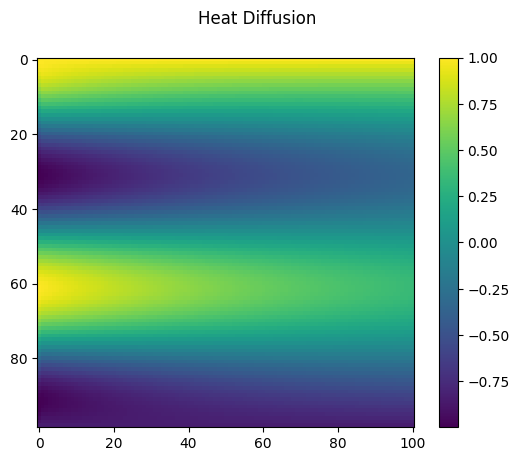

In [51]:
plt.imshow(lt.trajectory['u'].detach())
plt.suptitle('Heat Diffusion')
plt.colorbar()

# Simulate with Temporal Intervention

In [52]:
def heat_sink_intervention_fn(u):
    u = u.clone()
    u[59:65] = -1.0
    return u

heat_sink = StaticIntervention(
    time=tspan[67]-1e-10,
    intervention=dict(
        u=heat_sink_intervention_fn
    )
)

In [53]:
with solver, LogTrajectory(times=tspan) as lt_static, LogAtExtraDomains(xx), heat_sink:
    end_state = simulate(
        heat_dynamics,
        initial_state,
        torch.tensor(0.0),
        torch.tensor(1.0),
        atemp_params=atemp_params,
    )

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    36-element Vector{Float64}:
│     0.6699999999
│     0.67
│     0.6799999999999999
│     0.69
│     ⋮
│     0.99
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77


Andy fix the column-major row-major reshaping issues here.
Andy fix the column-major row-major reshaping issues here.
Andy fix the column-major row-major reshaping issues here.
Andy fix the column-major row-major reshaping issues here.


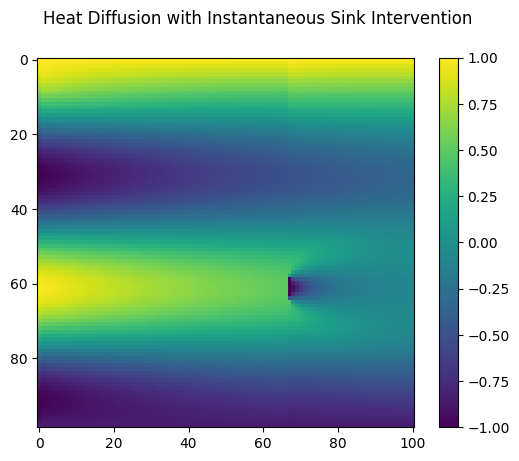

In [54]:
plt.imshow(lt_static.trajectory['u'].detach())
plt.suptitle('Heat Diffusion with Instantaneous Sink Intervention')
plt.colorbar()

# Simulate with State-Dependent Intervention

In [55]:
def event_fn(t, state, atemp_params):
    # Trigger an event when the temperature at discrete element 25 crosses -0.5
    return state['u'][25] - (-0.7)

In [56]:
def heat_spike_intervention_fn(u):
    u = u.clone()
    u[20:25] = 1.0
    return u

heat_spike = DynamicIntervention(
    event_fn=event_fn,
    intervention=dict(
        u=heat_spike_intervention_fn
    )
)

In [57]:
with solver, LogTrajectory(times=tspan) as lt_dynamic, LogAtExtraDomains(xx), heat_spike:
    end_state = simulate(
        heat_dynamics,
        initial_state,
        torch.tensor(0.0),
        torch.tensor(1.0),
        atemp_params=atemp_params,
    )

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    3-element Vector{Float64}:
│     0.0
│     0.16446173164040173
│     0.16446173164040173
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    86-element Vector{Float64}:
│     0.16446173164040173
│     0.17
│     0.18
│     0.19
│     ⋮
│     0.99
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77


Andy fix the column-major row-major reshaping issues here.
Andy fix the column-major row-major reshaping issues here.
Andy fix the column-major row-major reshaping issues here.
Andy fix the column-major row-major reshaping issues here.
Andy fix the column-major row-major reshaping issues here.


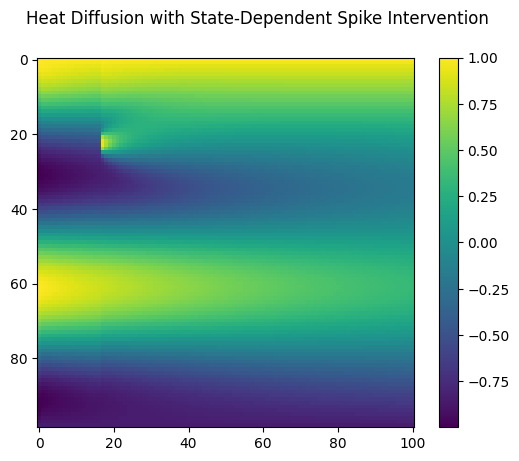

In [58]:
plt.imshow(lt_dynamic.trajectory['u'].detach())
plt.suptitle('Heat Diffusion with State-Dependent Spike Intervention')
plt.colorbar()

# Simulate with Both

In [59]:
with solver, LogTrajectory(times=tspan) as lt_both, LogAtExtraDomains(xx), heat_sink, heat_spike:
    end_state = simulate(
        heat_dynamics,
        initial_state,
        torch.tensor(0.0),
        torch.tensor(1.0),
        atemp_params=atemp_params,
    )

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    3-element Vector{Float64}:
│     0.0
│     0.16446173164040173
│     0.16446173164040173
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    36-element Vector{Float64}:
│     0.6699999999
│     0.67
│     0.6799999999999999
│     0.69
│     ⋮
│     0.99
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77


Andy fix the column-major row-major reshaping issues here.
Andy fix the column-major row-major reshaping issues here.
Andy fix the column-major row-major reshaping issues here.
Andy fix the column-major row-major reshaping issues here.
Andy fix the column-major row-major reshaping issues here.
Andy fix the column-major row-major reshaping issues here.
Andy fix the column-major row-major reshaping issues here.


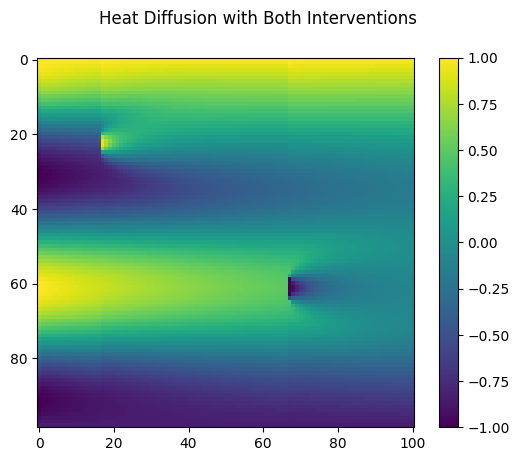

In [60]:
plt.imshow(lt_both.trajectory['u'].detach())
plt.suptitle('Heat Diffusion with Both Interventions')
plt.colorbar()